In [19]:
import matplotlib.pyplot as plt
import numpy as np
from genome import Genome
from kmer_model import kmer_model, predict, score_batch
from scipy import stats
%matplotlib inline

243573 243573
(156234, 4096) (156234,)
SpearmanrResult(correlation=0.32434400701637578, pvalue=0.0)
(0.37072967755102726, 0.0)


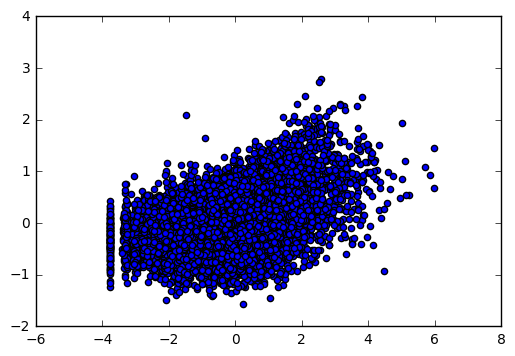

In [4]:
genome = Genome('../snps/hg19.fa')
model = kmer_model('../enhancer_data/kellis/standard/HepG2_ScaleUpDesign1_SV40P.fa',
                   '../enhancer_activities/kellis_HepG2_ScaleUpDesign1_SV40P.activities')

# Iterate through SNPs to get ones with valid entries DON'T RUN IF NOT NEEDED!

In [34]:
BATCH = 128
LENGTH = 145
with open('../snps/snp146.txt') as fp, open('../snps/valid_snp.txt', 'w') as out:
    batch = []
    for line in fp:
        (a, chrom, start, end, name, score, strand,
         ref1, ref2, diff, moltype, kind, valid, avHet,
         avHetSE, func, loctype, weight, exception,
         subCount, submitters, allelFreqCount, alleles,
         alleleNs, alleleFreqs, newline) = line.split('\t')
        if len(diff.split('/')) != 2: continue
        if kind != 'single': continue
        if kind == 'microsatellite': continue
        if len(alleleFreqs.split(',')) == 3:
            if chrom not in genome.genome.keys(): continue
            if sum(map(float, alleleNs.split(',')[:2])) < 5000: continue
            if not '1000GENOMES' in submitters.split(','): continue
            out.write('\t'.join([chrom, start, end, strand, alleleFreqs, diff]) + '\n')

# Load Variants

In [ ]:
predictor = lambda seqs: predict(seqs, model, 6)

BATCH = 128
LENGTH = 145
batch_count = 0
ref_preds, alt_preds,  ref_freqs = [], [], []
with open('../snps/valid_snp.txt') as fp:
    batch = []
    for line in fp:
        chrom, start, end, strand, alleleFreqs, diff = line.strip().split('\t')
        ref, alt = diff.split('/')[:2]
        if ref == '-': ref = ''
        if alt == '-': alt = ''
        batch += [(chrom, int(start)+2, ref, alt, True)]
        ref_freqs += [float(alleleFreqs.split(',')[0])] 
        if len(batch) == BATCH:
            rp, ap = score_batch(batch, predictor, genome, LENGTH)
            ref_preds += list(rp)
            alt_preds += list(ap)
            batch = []

ref_preds = np.array(ref_preds)
alt_preds = np.array(alt_preds)
ref_freqs = np.array(ref_freqs)

In [ ]:
# Get rid of 0% MAFs
maf = np.array([f if f < .5 else 1 - f for f in ref_freqs])
ref_preds = ref_preds[maf > 0]
alt_preds = alt_preds[maf > 0]
maf = maf[maf > 0]

# Scatter Allelic Skew

In [ ]:
plt.scatter(ref_preds, alt_preds, s = 2, alpha = .2)
plt.show()

# Scatter preds and frequency

In [ ]:
plt.hist(np.log10(maf), bins = 20)
plt.show()
plt.hist(ref_preds, bins = 100)
plt.show()
plt.hist(alt_preds, bins = 100)
plt.show()

In [ ]:
print stats.spearmanr(ref_preds, np.log10(maf))
plt.scatter(ref_preds, np.log10(maf), s = 2, alpha = .2)
plt.show()

In [ ]:
dif = np.abs(ref_preds - alt_preds)
print stats.spearmanr(dif, np.log10(maf))
plt.scatter(dif, np.log10(maf), s = 2, alpha = .2)
plt.show()

# CDF pred, MAF

In [ ]:
def cdf(a, b, l1, l2):
    print stats.ttest_ind(a, b)
    print a.mean(), b.mean()
    X = np.linspace(0, .6, 60)
    cdf = [sum(a < x) / float(a.shape[0]) for x in X]
    plt.plot(X, cdf, label = l1)
    cdf = [sum(b < x) / float(b.shape[0]) for x in X]
    plt.plot(X, cdf, label = l2)
    plt.legend()
    plt.show()

In [ ]:
high = maf[ref_preds > .5]
mid = maf[np.logical_and(ref_preds < .25,
                         ref_preds > -.25)]
low = maf[ref_preds < -.5]

print high.shape, mid.shape, low.shape

cdf(high, mid, 'high', 'mid')
cdf(low, mid, 'low', 'mid')

In [ ]:
high = maf[ref_preds > 1]
mid = maf[np.logical_and(ref_preds < .25,
                         ref_preds > -.25)]
low = maf[ref_preds < -1]

print high.shape, mid.shape, low.shape

cdf(high, mid, 'high', 'mid')
cdf(low, mid, 'low', 'mid')

In [ ]:
s_maf = maf[maf > .01]
s_ref_preds = ref_preds[maf > .01]
print s_maf.shape

high = s_maf[s_ref_preds > .5]
mid = s_maf[np.logical_and(s_ref_preds < .25,
                           s_ref_preds > -.25)]
low = s_maf[s_ref_preds < -.5]

print high.shape, mid.shape, low.shape

cdf(high, mid, 'high', 'mid')
cdf(low, mid, 'low', 'mid')

# Diff in activity

In [ ]:
diff = ref_preds - alt_preds
plt.hist(diff, bins = 100)
plt.show()
print np.median(diff)
print stats.spearmanr(diff, maf)
plt.scatter(diff, np.log10(maf))
plt.show()

In [ ]:
high = maf[diff > .1]
mid = maf[np.logical_and(diff < .1,
                         diff > -.1)]
low = maf[diff < -.1]

print high.shape, mid.shape, low.shape

cdf(high, mid, 'high', 'mid')
cdf(low, mid, 'low', 'mid')

In [ ]:
s_maf  = maf[maf > .01]
s_diff = diff[maf > .01]
print s_maf.shape

high = s_maf[s_diff > .1]
mid = s_maf[np.logical_and(s_diff < .1,
                           s_diff > -.1)]
low = s_maf[s_diff < -.1]

print high.shape, mid.shape, low.shape

cdf(high, mid, 'high', 'mid')
cdf(low, mid, 'low', 'mid')